<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/Universal_PyTorch2_trend_features_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [396]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and Utilities

In [397]:

import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday, persistence_probabilistic
# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [398]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "lat":21.446911,
        "lon":-158.188736,
        "fresh_data_time":'12',
    },
    'or': {
        "lat":45.114559,
        "lon":-123.204903,
        "fresh_data_time":'12',
    },
    'tx': {
        "lat":29.424122,
        "lon":-98.493629,
        "fresh_data_time":'06',
    },
    'ga': {
        "lat":31.044241,
        "lon":-84.879128,
        "fresh_data_time":'06',
    },

}
tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df




# def make_reference_forecasts(start_date, end_date, location)

#     location_meta_data = {
#         'tx': ['San Antonio, TX Substation',states['tx']['lat'],]
#     }


#     name = 'San Antonio, TX Substation'
#     latitude = lat
#     longitude = lon
#     elevation = 4.0
#     timezone = local_time_zone
#     site_id = 'c639b1f3-eb8f-11ed-802e-aec5a60999dc'
#     site = Site(name = name, latitude = latitude, longitude = longitude, elevation = elevation,
#                 timezone = timezone, site_id = site_id)

#     variable = 'net_load'
#     interval_value_type = 'interval_mean'
#     interval_length = pd.Timedelta(value = 1, unit = 'hour')
#     interval_label = 'ending'
#     site = site
#     uncertainty = 0
#     obs = Observation(name = name, variable = variable,
#                       interval_value_type = interval_value_type,
#                       interval_length = interval_length,
#                       interval_label = interval_label,
#                       site = site, uncertainty = uncertainty)

#     observation  = obs
#     data_start  = start_time
#     data_end = end_time
#     forecast_start = target_start_time
#     forecast_end  = target_end_time
#     interval_length = interval_length
#     interval_label = 'ending'
#     load_data = load_data
#     axis = 'x'
#     constant_values = np.array([x/10 for x in range(1,10)])


#     baseline = persistence_probabilistic(observation = obs,
#                                         data_start = data_start,
#                                         data_end = data_end,
#                                         forecast_start = forecast_start,
#                                         forecast_end = forecast_end,
#                                         interval_length = interval_length,
#                                         interval_label = interval_label,
#                                         load_data = load_data,
#                                         axis = 'y',
#                                         constant_values = constant_values)


# Feature engineering


In [399]:
state_location = 'ga'
training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/oregon_historical.csv')
total_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/oregon_2022-01-01-2023-06-28_total.csv')
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/oregon_2023-06-30_test.csv')

In [400]:
training_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
test_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)

training_data.drop(columns = 'quality_flag', inplace = True)
test_data.drop(columns = 'quality_flag', inplace = True)

In [401]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,2023-07-03T21:05,2023-07-03T05:29
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,2023-07-03T21:05,2023-07-03T05:29
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,2023-07-03T21:05,2023-07-03T05:29
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-07-03T21:05,2023-07-03T05:29


In [402]:
training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

In [403]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,2023-07-03T21:05,2023-07-03T05:29
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,2023-07-03T21:05,2023-07-03T05:29
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,2023-07-03T21:05,2023-07-03T05:29
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-07-03T21:05,2023-07-03T05:29


In [404]:
training_data['hours'] = np.sin((training_data.time.dt.hour - 12) / 24)
test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

In [405]:

test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.442454
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.404715
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.366273
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.327195
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27,-0.287549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,2023-07-03T21:05,2023-07-03T05:29,0.287549
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,2023-07-03T21:05,2023-07-03T05:29,0.327195
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,2023-07-03T21:05,2023-07-03T05:29,0.366273
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-07-03T21:05,2023-07-03T05:29,0.404715


In [406]:
test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = np.sin(((test_data.sunrise.dt.hour - 12) / 24) + ((((test_data.sunrise.dt.minute) / 60) - 12) / 24))
test_data.sunset = np.sin(((test_data.sunset.dt.hour - 12) / 24) + ((((test_data.sunset.dt.minute) / 60) - 12) / 24))

In [407]:
test_data

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise,hours
0,2023-06-01 01:00:00,0.281151,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.442454
1,2023-06-01 02:00:00,0.280982,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.404715
2,2023-06-01 03:00:00,0.291136,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.366273
3,2023-06-01 04:00:00,0.302375,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.327195
4,2023-06-01 05:00:00,0.345335,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.287549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,-0.121229,-0.697231,0.287549
787,2023-07-03 20:00:00,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,-0.121229,-0.697231,0.327195
788,2023-07-03 21:00:00,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,-0.121229,-0.697231,0.366273
789,2023-07-03 22:00:00,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.121229,-0.697231,0.404715


In [408]:
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)


training_data.sunrise = np.sin(((training_data.sunrise.dt.hour - 12) / 24) + ((((training_data.sunrise.dt.minute) / 60) - 12) / 24))
training_data.sunset = np.sin(((training_data.sunset.dt.hour - 12) / 24) + ((((training_data.sunset.dt.minute) / 60) - 12) / 24))

In [409]:
training_data['month'] = training_data.time.dt.month
test_data['month'] = test_data.time.dt.month

In [410]:
# training_data.shape
# ['prev_{}'.format(5) + '_' + col for col in training_data.drop(columns = 'time').columns]

In [411]:
old_cols = training_data.drop(columns = 'time').columns
lookback_start = 5
lookback_end = 9
lookback_dim = lookback_end - lookback_start + 1
trend_features = len(old_cols) * lookback_dim
for i in range(lookback_start, lookback_end + 1):
  new_cols = ['prev_{}'.format(i) + '_' + col for col in old_cols]
  training_data[new_cols] = training_data.shift(i * 24)[old_cols].values
  test_data[new_cols] = test_data.shift(i * 24)[old_cols].values



In [412]:
# trend_features = len(old_cols) * lookback_dim


In [413]:
# ['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]

In [414]:
training_data['std'] = training_data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)
test_data['std'] = test_data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)

In [415]:
# training_data.columns

In [416]:
# training_data = training_data[(training_data['prev_{}_value'.format(lookback_end)].isna() == False)].reset_index().drop(columns = 'index')

In [417]:
training_data.iloc[:,-90:]

,prev_5_temperature_2m,prev_5_relativehumidity_2m,prev_5_dewpoint_2m,prev_5_apparent_temperature,prev_5_precipitation,prev_5_cloudcover,prev_5_cloudcover_low,prev_5_cloudcover_mid,prev_5_cloudcover_high,prev_5_shortwave_radiation,...,prev_9_cloudcover_high,prev_9_shortwave_radiation,prev_9_direct_radiation,prev_9_diffuse_radiation,prev_9_direct_normal_irradiance,prev_9_sunset,prev_9_sunrise,prev_9_hours,prev_9_month,std
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12353,22.5,43.0,9.5,21.2,0.0,1.0,0.0,1.0,0.0,138.0,...,0.0,116.0,64.0,52.0,470.6,-0.136379,-0.694238,0.327195,5.0,0.028382
12354,19.9,51.0,9.5,18.2,0.0,2.0,0.0,3.0,0.0,19.0,...,0.0,13.0,5.0,8.0,103.3,-0.136379,-0.694238,0.366273,5.0,0.028598
12355,17.9,60.0,10.0,16.3,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.136379,-0.694238,0.404715,5.0,0.031568
12356,16.5,68.0,10.5,15.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.136379,-0.694238,0.442454,5.0,0.021037


In [418]:
new_df = training_data[(training_data.value.isna() == False) &
                   (training_data['prev_{}_value'.format(lookback_end)].isna() == False)].drop(columns = 'time')
# new_df = training_data[((training_data['time'] <= '2022-10-01 00:00:00') & (training_data['time'] >= '2022-05-01 00:00:00'))].drop(columns = 'time')


In [419]:
# new_df.iloc[:,-trend_features:]

In [420]:


val_df = test_data[(test_data.value.isna() == False) &
                   (test_data['prev_{}_value'.format(lookback_end)].isna() == False)].drop(columns = 'time')
test_df_new = test_data[test_data.value.isna() == True][-24-23:-23].reset_index().drop(columns = ['index','time'])

In [421]:
test_data[(test_data.value.isna() == False) & (test_data['prev_{}_value'.format(lookback_end)].isna() == False)]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_9_cloudcover_high,prev_9_shortwave_radiation,prev_9_direct_radiation,prev_9_diffuse_radiation,prev_9_direct_normal_irradiance,prev_9_sunset,prev_9_sunrise,prev_9_hours,prev_9_month,std
216,2023-06-10 01:00:00,0.280165,14.5,78,10.7,14.5,0.0,100,100,3,...,0.0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.442454,6.0,0.017607
217,2023-06-10 02:00:00,0.267712,14.0,81,10.8,13.8,0.0,30,0,26,...,0.0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.404715,6.0,0.017590
218,2023-06-10 03:00:00,0.266966,13.9,77,9.9,13.5,0.0,50,0,9,...,0.0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.366273,6.0,0.023186
219,2023-06-10 04:00:00,0.266970,12.5,80,9.1,11.7,0.0,100,100,40,...,0.0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.327195,6.0,0.020109
220,2023-06-10 05:00:00,0.276934,12.9,83,10.1,12.8,0.0,34,16,0,...,0.0,0.0,0.0,0.0,0.0,-0.128808,-0.698226,-0.287549,6.0,0.032663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,2023-06-28 12:00:00,0.268544,23.2,55,13.7,26.0,0.0,0,0,0,...,0.0,298.0,9.0,289.0,77.9,-0.121918,-0.700212,0.000000,6.0,0.065519
660,2023-06-28 13:00:00,0.287403,25.0,49,13.5,28.0,0.0,0,0,0,...,0.0,85.0,0.0,85.0,1.1,-0.121918,-0.700212,0.041655,6.0,0.074729
661,2023-06-28 14:00:00,0.329631,26.3,45,13.4,29.2,0.0,0,0,0,...,0.0,331.0,0.0,331.0,0.0,-0.121918,-0.700212,0.083237,6.0,0.046112
662,2023-06-28 15:00:00,0.381390,28.2,40,13.3,30.9,0.0,0,0,0,...,0.0,425.0,51.0,374.0,51.0,-0.121918,-0.700212,0.124675,6.0,0.078727


In [422]:
val_df=val_df[new_df.columns]
test_df_new=test_df_new[new_df.columns]

# Train Val Split

In [423]:
X_train = new_df[[col for col in new_df.columns if col != 'value']]
y_train = new_df.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


In [424]:
X_val = val_df[[col for col in val_df.columns if col != 'value']]
y_val = val_df.value
X_val = torch.from_numpy(X_val.values).to(torch.float64)
y_val = torch.from_numpy(y_val.values).to(torch.float64)

# Defining models

In [425]:
class TrendsModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(TrendsModel, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
    # self.fc2 = nn.Linear(hidden_dim, 1).to(torch.float64)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
    self.fc4 = nn.Linear(hidden_dim, int(0.7 * hidden_dim)).to(torch.float64)
    self.fc5 = nn.Linear(int(0.7 * hidden_dim), int(0.7 * hidden_dim)).to(torch.float64)
    self.fc6 = nn.Linear(int(0.7 * hidden_dim), int(0.5 * hidden_dim)).to(torch.float64)
    # self.fc7 = nn.Linear(int(0.5 * hidden_dim), 1).to(torch.float64)
    self.relu = nn.ReLU().to(torch.float64)
    # self.softplus = nn.Softplus().to(torch.float64)
    self.softmax = nn.Softmax().to(torch.float64)
  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    x = self.relu(x)
    x = self.fc6(x)
    # x = self.relu(x)
    # x = self.fc7(x)
    return x

class FeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(FeaturesModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.relu = nn.ReLU().to(torch.float64)
        # self.softplus = nn.Softplus().to(torch.float64)
        self.softmax = nn.Softmax().to(torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        # x = self.relu(x)
        # x = self.fc7(x)
        return x

class Trend_Feature_model(nn.Module):
  def __init__(self, feature_dim, feature_hidden, trend_features_dim, hidden_dim, output_dim, trend_weight = 0.4):
    super(Trend_Feature_model, self).__init__()
    print(trend_features_dim, hidden_dim, output_dim)
    self.trends_model = TrendsModel(trend_features_dim, hidden_dim, output_dim)
    self.features_model = FeaturesModel(feature_dim, feature_hidden, output_dim)
    self.combining_layer = nn.Linear(feature_hidden +  int(0.5 * hidden_dim), min([feature_hidden, int(0.5 * hidden_dim)])).to(torch.float64)
    self.output_layer = nn.Linear(min([feature_hidden, int(0.5 * hidden_dim)]), 1).to(torch.float64)
    self.trend_weight = trend_weight
    self.relu = nn.ReLU().to(torch.float64)
    self.trend_features_dim = trend_features_dim
    self.hidden_dim = hidden_dim
  def forward(self, x):
    x_features = x[:,:-1 * (self.trend_features_dim + 1)]
    x_lookback = x[:,-1 * (self.trend_features_dim + 1): -1]
    std_hour = x[:,-1].view(-1,1)
    feature_output = self.features_model(x_features)
    trends_output = self.trends_model(x_lookback)
    # x = (feature_output * (1 - self.trend_weight)) + (trends_output * self.trend_weight)
    x = torch.concat([feature_output,trends_output], axis = 1).to(torch.float64)
    # print(x.shape, self.hidden_dim)
    x = self.relu(x)
    x = self.combining_layer(x)
    x = self.relu(x)
    x = self.output_layer(x)




    vals = []
    for i in range(0, 11):
      q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

      #gaussian quantile func.
      # pred2 = x + (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

      #uniform distribution:
      b = x + std_hour
      a = x - std_hour
      pred2 = (b * q) + (a * (1 -  q))

      vals.append(pred2)

    x = torch.concat(vals, dim = 1)#.detach().numpy()

    return x



# Loss Functions

In [426]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()


def negLL(y_pred, y_true):
    mu = y_pred[:,6]
    # prob_0 = y_pred[:,0]
    # prob_100 = y_pred[:,-1]
    # print("y_pred.shape",y_pred.shape,"y_true.shape",y_true.shape)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((mu - y_true)/ 2) ** 2) #- torch.log(denom)
    # loss += 0.1 * (((prob_0 - y_true)/ 2) ** 2)
    # loss += 0.1 * (((prob_100 - y_true)/ 2) ** 2)
    return loss.mean()

def negLL2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((y_pred - obs)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def mae(y_pred, y_true):
    mu = y_pred[:,0]
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((mu - y_true))) #- torch.log(denom)
    return loss.mean()

def mae2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((y_pred - obs)/ 2)) #- torch.log(denom)
    return loss.mean()

#Dataloader

In [427]:

class CDataset(Dataset):
    def __init__(self, X, y):
        self.X = X#.values
        self.y = y#.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# Training Loop

In [429]:
# from torch._C import float64
# Define the custom data loaders
batch_size = 64
train_dataset = CDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
feature_dim = X_train.shape[1] - trend_features - 1#22  # Specify the input feature dimensions
feature_hidden = 16
trend_features_dim = trend_features
lookback_hidden = int(trend_features * 0.8)

model = Trend_Feature_model(feature_dim = feature_dim, feature_hidden = int(feature_dim * 0.8),
                            trend_features_dim = trend_features_dim,
                            hidden_dim = lookback_hidden,
                            output_dim = 1,
                            trend_weight=0.9)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

            outputs = model(batch_X)
            # print(outputs.shape)
            # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
            loss = negLL(outputs, batch_y)
            # loss = mae(outputs, batch_y)
            # loss = crps_loss(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
        loss = crps_loss(outputs, batch_y)
        # loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/len(train_loader))
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


90 72 1
Epoch [1/150], Train Loss: 0.08032285163037167, Val Loss: 0.0274891718157087
Epoch [2/150], Train Loss: 0.05497397879270863, Val Loss: 0.003124863268938258
Epoch [3/150], Train Loss: 0.08250347473679515, Val Loss: 0.0023134945437070964
Epoch [4/150], Train Loss: 0.05833947476034035, Val Loss: 0.0020401480818732546
Epoch [5/150], Train Loss: 0.0518510696019611, Val Loss: 0.0026918524742276274
Epoch [6/150], Train Loss: 0.04368325678952365, Val Loss: 0.0012229461996741528
Epoch [7/150], Train Loss: 0.04635908208993798, Val Loss: 0.000839496858789132
Epoch [8/150], Train Loss: 0.03914645641719599, Val Loss: 0.0009236689422171226
Epoch [9/150], Train Loss: 0.04498047246761735, Val Loss: 0.0007816693903437976
Epoch [10/150], Train Loss: 0.04251328214598702, Val Loss: 0.0008168427224092594
Epoch [11/150], Train Loss: 0.04110185665276941, Val Loss: 0.0009767755523429928
Epoch [12/150], Train Loss: 0.04277872605153767, Val Loss: 0.0007685213135961293
Epoch [13/150], Train Loss: 0.04092

In [430]:
# test_data

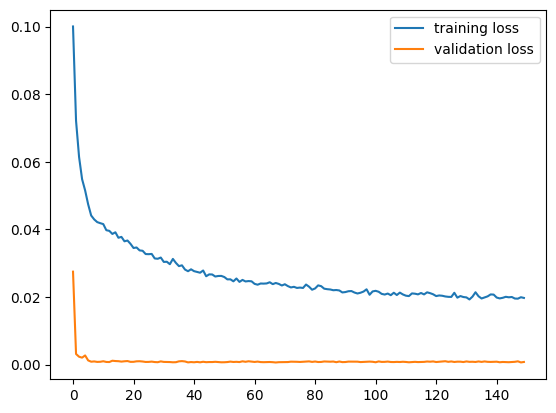

In [431]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

# Inspection Space

In [432]:
weather_cols = ['dewpoint_2m','relativehumidity_2m','temperature_2m',
                'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
                'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
                'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']
weather_dictionary = {col:[] for col in weather_cols}

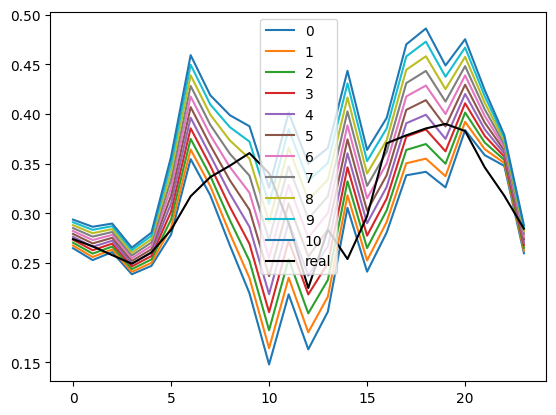

0.024731867550245853 0.189330369179742


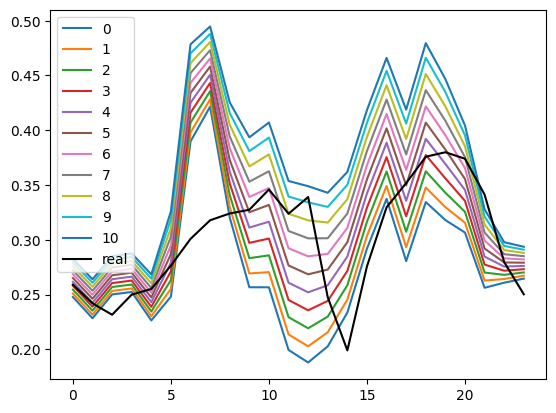

0.03188570633409223 0.25516550848927577


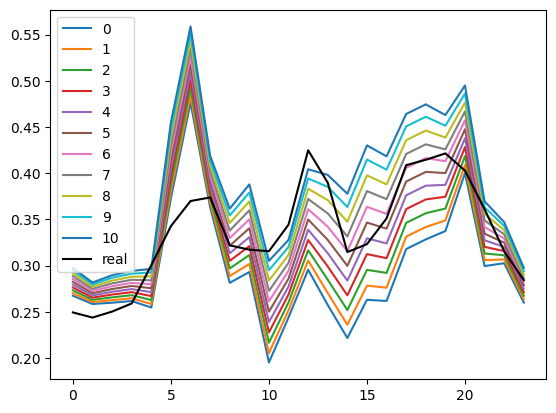

0.02720867850387135 -0.02717446669347634


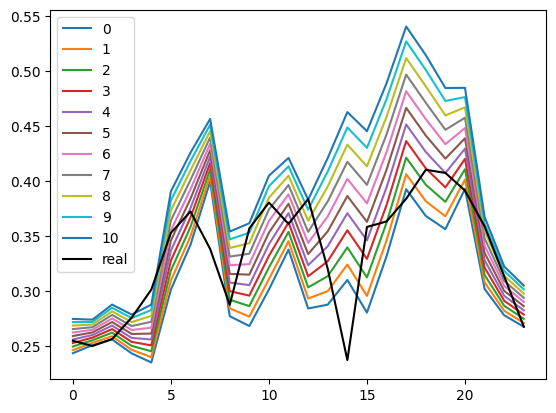

0.02493768042424588 0.19060932641764694


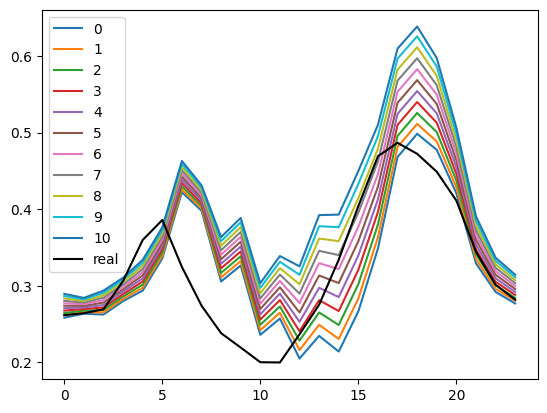

0.043008023144615354 -0.7791432873264714


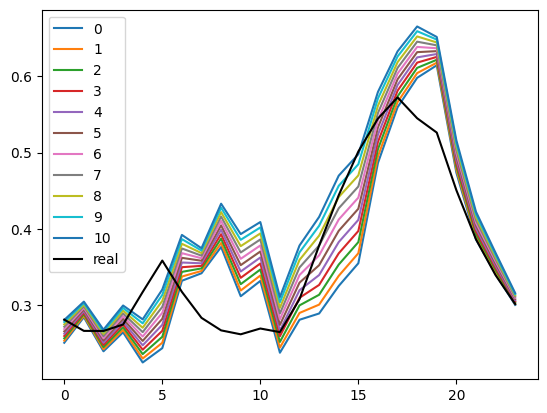

0.039399904864644585 -0.28026589078900743


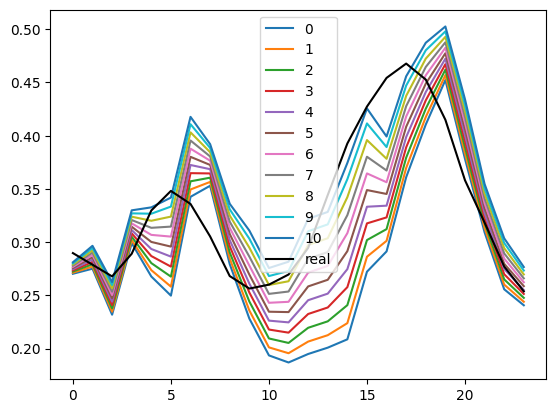

0.030346532187758974 -0.15236963385950042


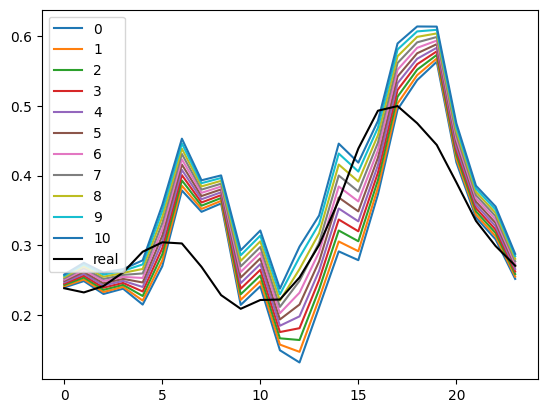

0.043146088893892875 -0.523556558554962


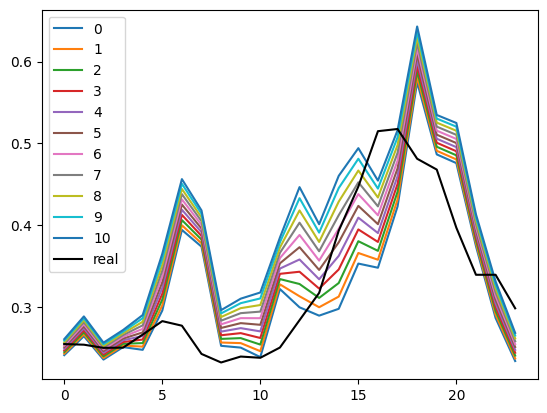

0.047327166218201926 -0.5195146546612124


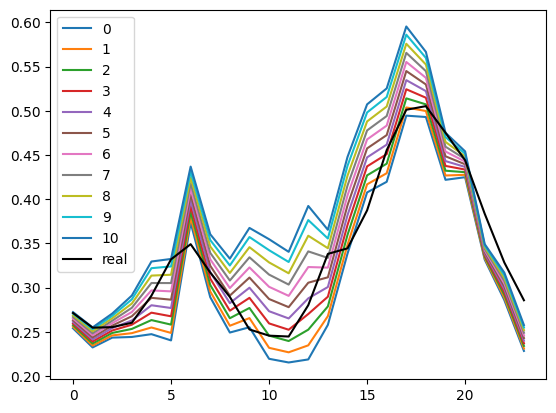

0.020624257700125267 -0.2580848133785294


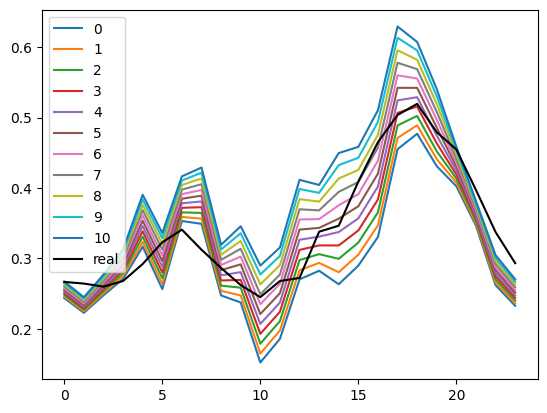

0.023338479426389183 -0.2036549308753508


In [433]:
daily_crps = []
daily_crpss = []
for day in range(18, 29):

  start_date = '2023-06-{:02d}'.format(day - 1)
  end_date = '2023-06-{:02d}'.format(day)
  test_df = test_data[(test_data.time >= start_date + ' 01:00:00')
                    & (test_data.time <= end_date + ' 00:00:00')].drop(columns = 'time')

  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  hourly_deviations = []
  meanies = []
  std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


  vals = []
  for i in range(0, 11):
    # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()

  for col in weather_cols:
    weather_data = test_df[col].values
    weather_dictionary[col].append(test_df[col].std())


  pred = preds.detach().numpy()#torch.concat(vals, dim = 1).detach().numpy()

  # submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
  # submission['timestamp'] = pd.date_range(start = '2023-06-{0:2d} 01:00:00'.format(day - 1),
  #                                         end =  '2023-06-{0:2d} 00:00:00'.format(day),
  #                                         freq='H',
  #                                         tz = states['ga']['local_time_zone']
  #                                         )

  # submission[['p' + str(i*10) for i in range(11)]] = pred



  obs = y_test.detach().numpy()
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
  crps, crpss, _ = crps_and_crpss_scores(obs, pred, start_date, end_date, state_location)
  print(crps, crpss)
  daily_crps.append(crps)
  daily_crpss.append(crpss)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

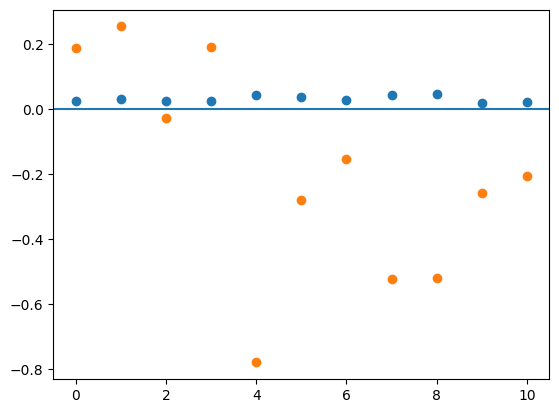

In [434]:
plt.scatter(range(len(daily_crps)), daily_crps)
plt.scatter(range(len(daily_crpss)), daily_crpss)
plt.axhline(0)
plt.show()

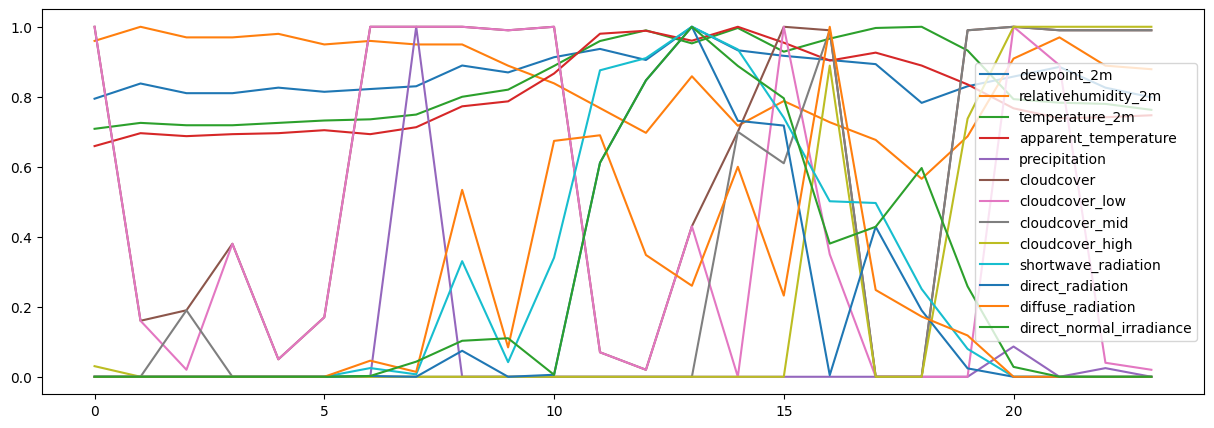

In [ ]:
day = 23
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  weather_dictionary[col].append(test_df[col].std())
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

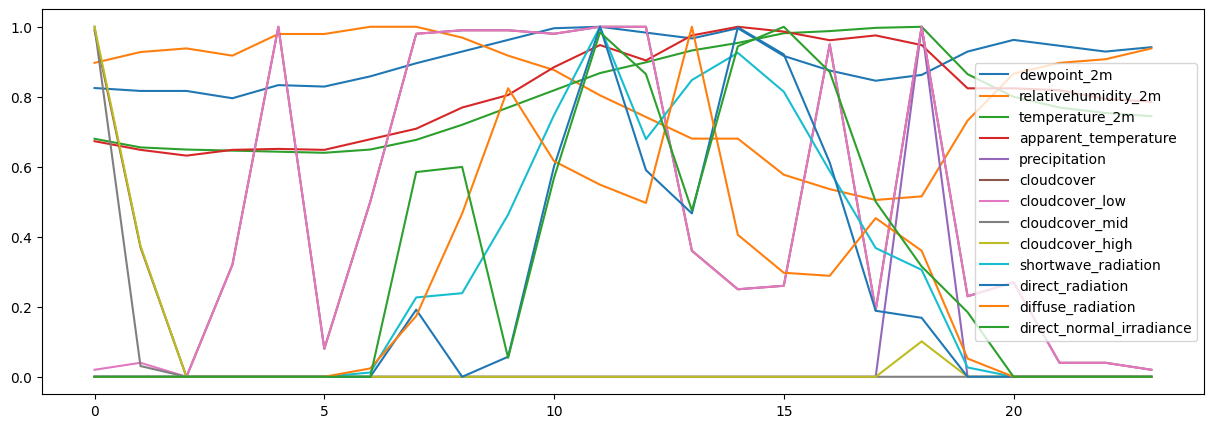

In [ ]:
day = 24
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

In [ ]:
# current_day = -1
# biases = []
# predictions = []
# observations = []
# for i in range(lookback_start, lookback_end + 1):
#   test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
#   X_test = test_df[[col for col in test_df.columns if col != 'value']]
#   y_test = test_df.value
#   X_test = torch.from_numpy(X_test.values).to(torch.float64)
#   y_test = torch.from_numpy(y_test.values).to(torch.float64)

#   preds = model(X_test)

#   predictions.append(preds)
#   observations.append(y_test)

# mean_pred = torch.zeros((24,1))
# mean_obs = torch.zeros((24,1))

# for i in range(lookback_dim):
#   mean_pred += predictions[i]
#   mean_obs += observations[i].view(24,1)

# mean_obs /= lookback_dim
# mean_pred /= lookback_dim

# test_df = test_data[-23-24:-23].drop(columns = 'time')
# X_test = test_df[[col for col in test_df.columns if col != 'value']]
# y_test = test_df.value
# X_test = torch.from_numpy(X_test.values).to(torch.float64)
# y_test = torch.from_numpy(y_test.values).to(torch.float64)

# preds = model(X_test)

# hourly_deviations = []
# meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


# vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias


#   pred2 = preds + std_hour * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
#   plt.plot(pred2.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

# pred = torch.concat(vals, dim = 1).detach().numpy()


# BIAS CORRECTION AND SUBMISSION

In [ ]:
test_df = test_data[-23-24-24:-23-24]#.drop(columns = 'time')

In [ ]:
current_day = -1
biases = []
predictions = []
observations = []
for i in range(lookback_start, lookback_end + 1):
  test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  predictions.append(preds)
  observations.append(y_test)

mean_pred = torch.zeros((24,1))
mean_obs = torch.zeros((24,1))

for i in range(lookback_dim):
  mean_pred += predictions[i]
  mean_obs += observations[i].view(24,1)

mean_obs /= lookback_dim
mean_pred /= lookback_dim

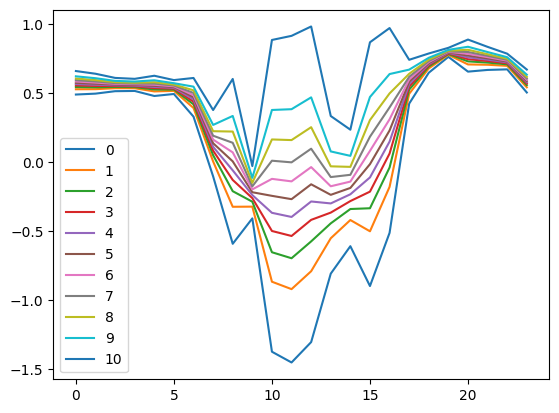

In [ ]:
# j = 1
# trial_x, trial_y = X_test[-24 * (j): -24 * (j-1)], y_test[-24 * (j): -24 * (j-1)]

test_df = test_data[-23-24-24:-23-24].drop(columns = 'time')
X_test = test_df[[col for col in test_df.columns if col != 'value']]
y_test = test_df.value
X_test = torch.from_numpy(X_test.values).to(torch.float64)
y_test = torch.from_numpy(y_test.values).to(torch.float64)

preds = model(X_test)#torch.from_numpy(X).to(torch.float64))#.shape

hourly_deviations = []
meanies = []
std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)#new_df[new_df['hour'] == float(i)]['value'].std()


vals = []
for i in range(0, 11):
  q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
  bias = mean_pred - mean_obs
  corrected_mean = preds - bias#(preds - mean)


  pred2 = preds +  (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

  vals.append(pred2)
  plt.plot(pred2.detach().numpy(), label = str(i))

plt.legend()
plt.show()

pred = torch.concat(vals, dim = 1).detach().numpy()

# Submission Block

In [ ]:
from datetime import datetime


In [ ]:
submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
submission['timestamp'] = pd.date_range(start = '2023-07-01 01:00:00',
                                         end =  '2023-07-02 00:00:00',
                                         freq='H',
                                         tz = states[state_location]['local_time_zone']
                                         )
submission[['p' + str(i*10) for i in range(11)]] = pred

submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/hi_pytorch2_submission_{}.csv".format(datetime.now()))

upload_function(submission.set_index('timestamp'),state_location)